In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image  # Import PIL to resize images
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

2024-05-20 13:58:55.387926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 13:58:55.388029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 13:58:55.515649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/tmp/ipykernel_34/407631902.py:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


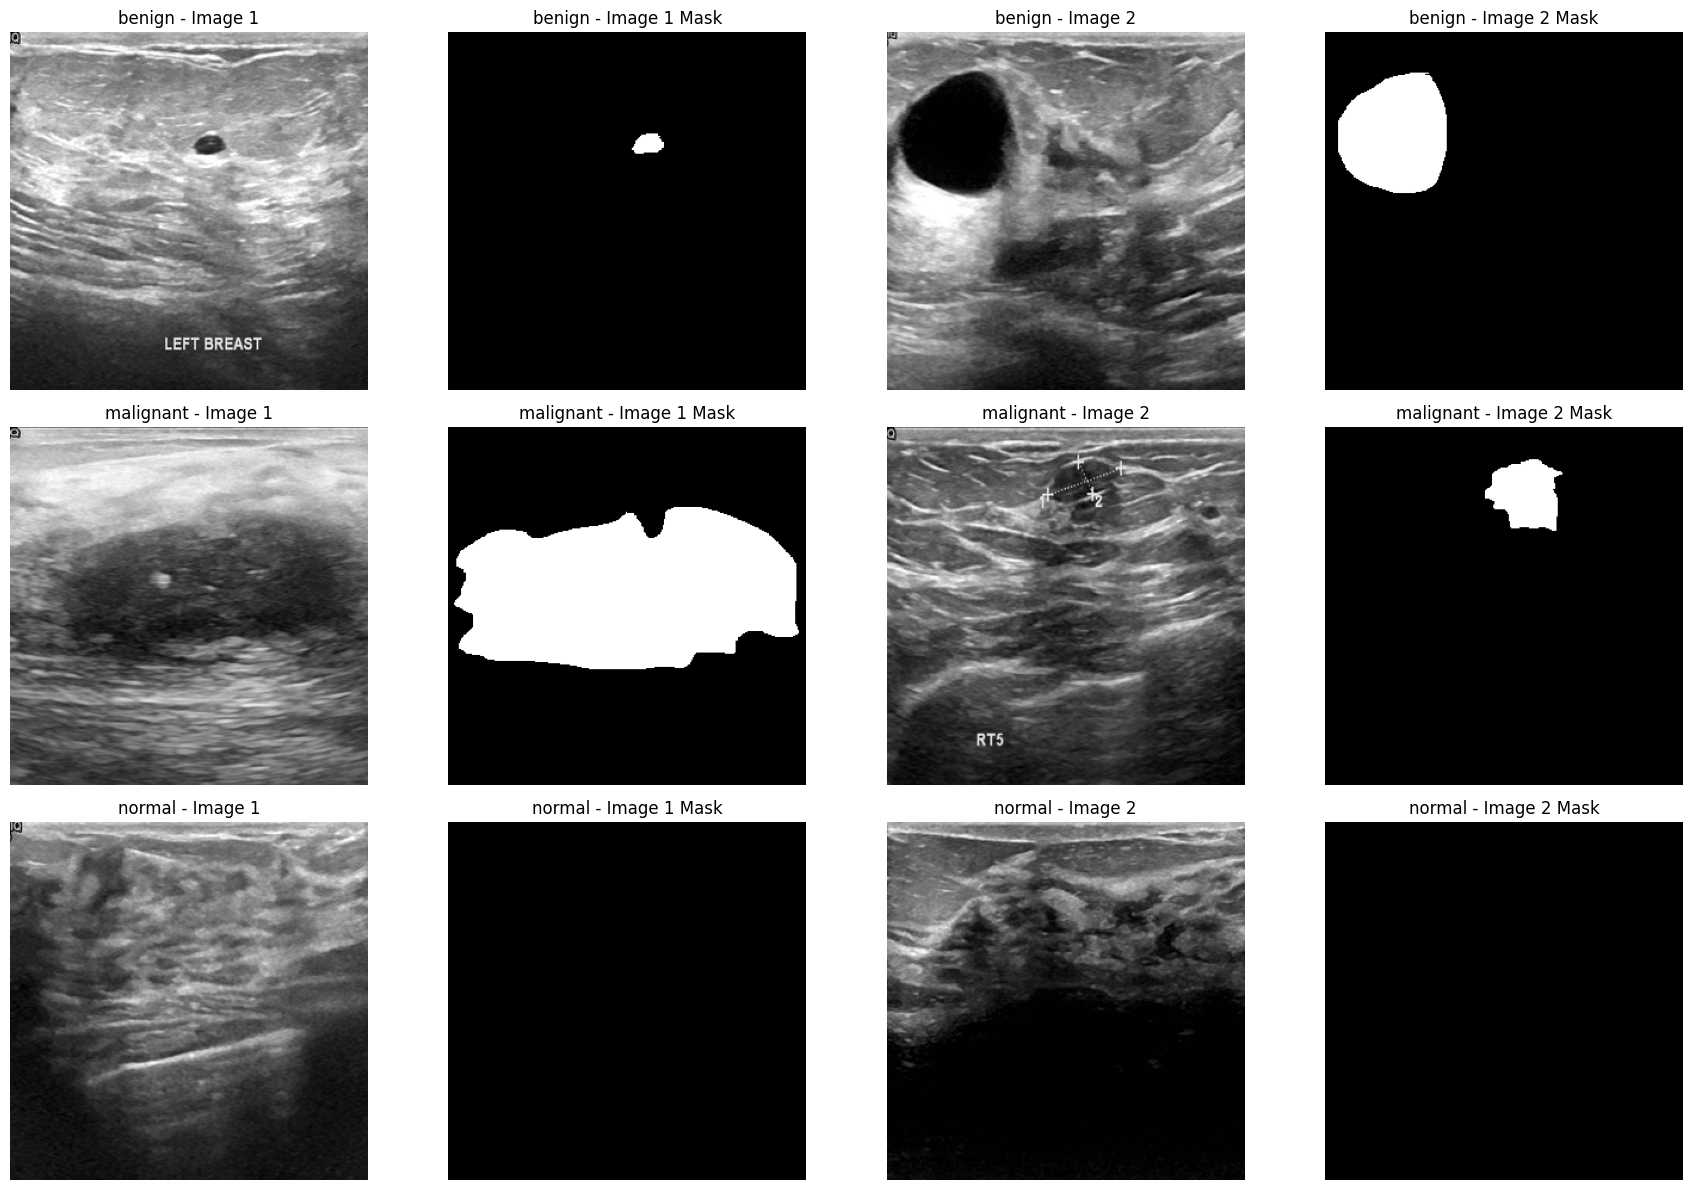

In [2]:
# 定义标签和对应的目录
labels = ['benign', 'malignant', 'normal']
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
# 创建一个图形来显示图像
fig, axs = plt.subplots(3, 4, figsize=(18, 12))

# Desired width and height for each image
desired_width = 300  # Adjust as needed
desired_height = 300  # Adjust as needed

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    
    # Get a list of image files
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]
    
    # Sort the list of image files
    image_files = sorted(image_files)
    
    # Loop through the first 4 image files
    for j in range(4):
        if j < len(image_files):
            # Load and resize the image
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
            
            # Determine the label based on whether it's an image or a mask
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'
            
            # Display the image with the corresponding label
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Set the path to the Kaggle working directory
working_dir = '/kaggle/working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Kaggle working directory has been cleared.")


Kaggle working directory has been cleared.


In [4]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Define the training function with early stopping and additional features
# Lists to store training and validation losses
train_losses = []
val_losses = []
def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')  # Initialize best_loss with a large value
    consecutive_epochs_without_improvement = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Append training loss here
                if phase == 'train':
                    train_losses.append(loss.item())  # Append training loss
                else:
                    val_losses.append(loss.item())  # Append validation loss

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Early stopping: Check if validation loss improved
            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        # Check if early stopping criteria are met
        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))
   
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Calculate classification report and confusion matrix for validation data
    y_true = []
    y_pred = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate classification report
    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    return model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import warnings

# Suppress DeprecationWarning and ResourceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

# Set the path to the input folder containing images and masks
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

# Set the path to the output folder where overlayed images will be saved
output_dir = '/kaggle/working/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Function to overlay images and masks, resize if needed, and save the result
def overlay_and_save(image_path, mask_path, output_path):
    try:
        # Check if both image and mask files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Open the actual image and mask image
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Ensure both images have the same color mode
            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            # Resize the images if their sizes don't match
            if image.size != mask.size:
                image = image.resize(mask.size)

            # Overlay the image with the mask
            overlayed = Image.blend(image, mask, alpha=0.5)

            # Save the overlayed image to the appropriate label folder
            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            #print(f"File not found for: {image_path} or {mask_path}. Skipping...")
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Iterate through the subdirectories (benign, malignant, normal)
for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                # Construct the mask file path based on the naming convention
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /kaggle/working/OverlayedImages directory.")

In [ ]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
import os

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Set the paths to the input and output directories
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
output_dir = '/kaggle/working/OverlayedImages'

# Count the files in the input and output directories
input_counts = {}
output_counts = {}

# Count files in input directory
for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

# Count files in output directory
for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

# Print file counts
print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")


In [ ]:
# Set the path to the overlayed images directory
overlayed_dir = '/kaggle/working/OverlayedImages'

# Create subdirectories for each label
labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

# Create a figure to display the images
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Desired width and height for each image
desired_width = 800  # Adjust as needed
desired_height = 800  # Adjust as needed

# Loop through each label and display the first 4 images
for i, label_dir in enumerate(label_dirs):
    # Get a list of image files and sort them
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))  # Sort the images by number in parentheses

    for j, image_filename in enumerate(images[:4]):  # Display the first 4 images
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        # Resize the image to the desired width and height
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        # Display the image in the subplot
        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()

In [ ]:
# Define the directory paths
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/benign'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'benign (10).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Define the directory paths
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/malignant'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'malignant (103).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the directory paths
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/normal'

# Create a figure to display the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Desired width and height for display
desired_width = 300
desired_height = 300

# Select an image (change the index as needed)
image_filename = 'normal (1).png'

# Construct the file paths
actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

# Load the images
actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

# Resize the images
actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

# Display the images
axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Set the path to your input folder
data_dir = '/kaggle/working/OverlayedImages'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

# Define the paths for the train, validation, and test directories
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy the images to the corresponding directories
for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

In [ ]:
import os
train_dir = '/kaggle/working/train'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
   # print("Train folder counts including masks:")
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("Validation folder counts including masks:")
    print(f"Validation {category}: {count}")


test_dir = '/kaggle/working/test'

# List the subdirectories (benign, malignant, normal)
subdirectories = ['benign', 'malignant', 'normal']

# Dictionary to store file counts
file_counts = {}

# Loop through the subdirectories and count files in each
for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

# Print the file counts
for category, count in file_counts.items():
    #print("test folder counts including masks:")
    print(f"test {category}: {count}")

In [ ]:
data_dir='/kaggle/working/'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 32  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)